<a href="https://colab.research.google.com/github/yrelisgorau/MoEDAL-ML-ANA/blob/main/traincnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  mount google drive to get access to the data sets
from google.colab import drive
drive.mount('/content/drive')


# clone the repo with the modules (and this file)
!git clone https://github.com/yrelisgorau/MoEDAL-ML-ANA

# add work area to the PYTHONPATH
import sys
sys.path.append('/content/MoEDAL-ML-ANA/modules')

imagePath='/content/drive/My Drive/Colab Notebooks/moedal-examples/pits_frontback_2d'

Mounted at /content/drive
Cloning into 'MoEDAL-ML-ANA'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 268 (delta 79), reused 235 (delta 59), pack-reused 0 (from 0)
Receiving objects: 100% (268/268), 7.87 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
def open_pits(file):
    pits = 0
    with open(file,'rb') as pickle_file:
        pits = pickle.load(pickle_file)
    # pits is a dictionary containing signal pits and background pits,
    # for front surface, and reverse surface (r)

    sig = pits['sig']
    sigr = pits['sigr']
    bkg = pits['bkg']
    bkgr = pits['bkgr']
    # pits are stored as a list of tuples
    # pit_tuple = (slide index, x_pos, y_pos, 28*28 numpy array / image)

    pit = sigr[0] # take 1st element in list
    pit = pit[3] # take the image

    sig_images = [ z[3] for z in sig ] # convert sig into a list of images
    sig_array = np.asarray(sig_images) #can convert into array
    bkg_images = [ j[3] for j in bkg ]
    bkg_array = np.asarray(bkg_images)

    """
    making labeled datasets from these lists

    Either use ds label on a list to make a dataset
    this can be concatenated and shuffled with the bkg dataset

    Or generate a label array (see ds label), and use the arrays directly
    """

#    sig_dataset = ds_label(sig_images,(1.0,0.0))
#    bkg_dataset = ds_label(bkg_images,(0.0,1.0))
    sig_label = [(1.0,0.0) for l in sig_array]
    bkg_label = [(0.0,1.0) for l in bkg_array]

    return sig_array, bkg_array, sig_label, bkg_label

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def k_sequential():
    """
    Default model used in Xe Ion study
    """
    model = keras.Sequential()
    model.add(keras.Input(shape=(28,28,1))) # specifying input
    model.add(layers.Conv2D(32, kernel_size = (3,3), padding='same',activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(32, kernel_size = (3,3), padding='same',activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(32, kernel_size = (3,3), padding='same',activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(32, kernel_size = (3,3), padding='same',activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.GlobalMaxPooling2D()) # compress to 1 spatial dimension
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(2, activation = 'softmax'))
    model.summary()
    return model

In [ ]:
from sklearn.model_selection import train_test_split
def training():
    model = k_sequential() # create the compiled model
    s,b,sl,bl = open_pits(imagePath+'/pits_checked') # get the data

    print('opened the inputs',flush=True)
    print(s.shape)
    print(b.shape)

    data_all = np.concatenate((s,b),axis=0)
    label_all = np.concatenate((sl,bl),axis=0)
    print(data_all.shape,label_all.shape)


    data_train, data_test, label_train, label_test  = train_test_split(data_all,label_all,test_size=0.5,random_state=42)
    print(len(data_train),len(label_train))
#
    print('hello', flush=True)


    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[keras.metrics.BinaryAccuracy, keras.metrics.BinaryCrossentropy],run_eagerly=False)
    print('model compiled',flush=True)
    history = model.fit(data_train,label_train, batch_size = 10, epochs=7,verbose=1,validation_data=(data_test,label_test))

    print('Done',flush=True)
    return history,model

In [ ]:
training()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,186 (114.01 KB)

 Trainable params: 29,186 (114.01 KB)

 Non-trainable params: 0 (0.00 B)

opened the inputs
(1299, 28, 28)
(1471, 28, 28)
(2770, 28, 28) (2770, 2)
1385 1385
hello
model compiled
Epoch 1/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - binary_accuracy: 0.6727 - binary_crossentropy: 0.6058 - loss: 0.5664 - val_binary_accuracy: 0.9256 - val_binary_crossentropy: 0.2984 - val_loss: 0.2311
Epoch 2/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9260 - binary_crossentropy: 0.3048 - loss: 0.2257 - val_binary_accuracy: 0.9242 - val_binary_crossentropy: 0.3065 - val_loss: 0.2548
Epoch 3/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0.9380 - binary_crossentropy: 0.2815 - loss: 0.2118 - val_binary_accuracy: 0.9264 - val_binary_crossentropy: 0.3319 - val_loss: 0.2314
Epoch 4/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9371 - binary_crossentropy: 0.2892 - loss: 0.2029 - val_binary_accuracy: 0.9256 - val_binary_crossentropy: 0.2889 - val_loss: 0.2217
Epoch 5/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_accuracy: 0

(<keras.src.callbacks.history.History at 0x7cd800676ed0>,
 <Sequential name=sequential, built=True>)

In [ ]:
def plot_training_metrics(history):
    # Check available keys
    print("Available metrics:", history.history.keys())

    # Extract metrics with correct keys
    acc = history.history.get('binary_accuracy')
    val_acc = history.history.get('val_binary_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Accuracy
    plt.figure()
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Loss
    plt.figure()
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure()
    plt.plot(epochs, val_loss, label='Validation Loss', color='green')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,186 (114.01 KB)

 Trainable params: 29,186 (114.01 KB)

 Non-trainable params: 0 (0.00 B)

opened the inputs
(1299, 28, 28)
(1471, 28, 28)
(2770, 28, 28) (2770, 2)
1385 1385
hello
model compiled
Epoch 1/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - binary_accuracy: 0.7784 - binary_crossentropy: 0.5570 - loss: 0.4917 - val_binary_accuracy: 0.9206 - val_binary_crossentropy: 0.3571 - val_loss: 0.2506
Epoch 2/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - binary_accuracy: 0.9218 - binary_crossentropy: 0.3330 - loss: 0.2454 - val_binary_accuracy: 0.9235 - val_binary_crossentropy: 0.3152 - val_loss: 0.2582
Epoch 3/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.9326 - binary_crossentropy: 0.3066 - loss: 0.2295 - val_binary_accuracy: 0.9278 - val_binary_crossentropy: 0.2752 - val_loss: 0.2282
Epoch 4/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - binary_accuracy: 0.9296 - binary_crossentropy: 0.2920 - loss: 0.2164 - val_binary_accuracy: 0.9271 - val_binary_crossentropy: 0.2790 - val_loss: 0.2283
Epoch 5/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0

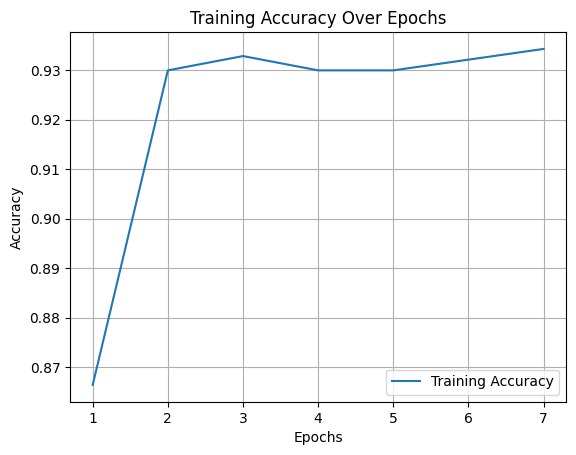

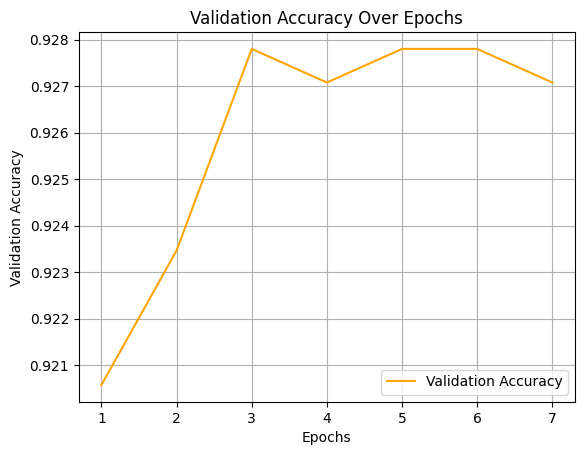

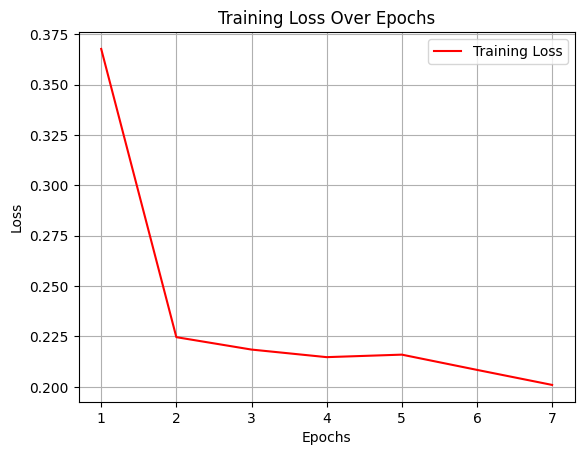

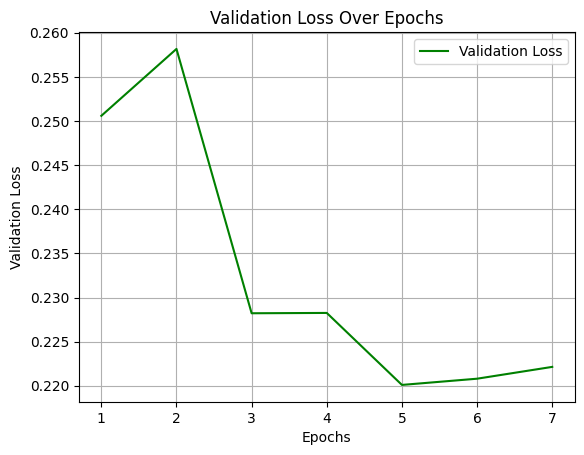

In [ ]:

history, model=training()
plot_training_metrics(history)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Overfitting Model

# Overfitting Model (Structured Similar to Base Model)
def overfitting_cnn():
    """
    Overfitting model with structure similar to the base `k_sequential` model.
    """
    model = keras.Sequential()
    model.add(keras.Input(shape=(28, 28, 1)))  # Specifying input
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.GlobalMaxPooling2D())  # Compress to 1 spatial dimension
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    # Increased learning rate for faster convergence
    optimizer = keras.optimizers.Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def train_overfitting_model(imagePath):
    model = overfitting_cnn()

    # load data
    s, b, sl, bl = open_pits(imagePath + '/pits_checked')

    # use only a small subset of data to encourage overfitting
    s = s[:200]
    b = b[:200]
    sl = sl[:200]
    bl = bl[:200]

    # normalize data
    s, b = s / 255.0, b / 255.0

    # prepare data
    data_all = np.concatenate((s, b), axis=0)
    label_all = np.concatenate((sl, bl), axis=0)

    data_train, data_val, label_train, label_val = train_test_split(
        data_all, label_all, test_size=0.5, random_state=42
    )

    # reduced epochs for faster training
    history = model.fit(
        data_train,
        label_train,
        epochs=200,
        batch_size=16,
        validation_data=(data_val, label_val),
        verbose=1
    )

    return history

# plotting validation accuracy

def plot_validation_accuracy(history):
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(val_acc) + 1)

    plt.figure()
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy Over Epochs (Overfitting Demonstration)')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()




Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4408 - loss: 0.6999 - val_accuracy: 0.4650 - val_loss: 0.7055
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5796 - loss: 0.6890 - val_accuracy: 0.4650 - val_loss: 0.6953
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5271 - loss: 0.6976 - val_accuracy: 0.4650 - val_loss: 0.6992
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5521 - loss: 0.6921 - val_accuracy: 0.4650 - val_loss: 0.6942
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5294 - loss: 0.6943 - val_accuracy: 0.4650 - val_loss: 0.7267
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5158 - loss: 0.7111 - val_accuracy: 0.4650 - val_loss: 0.7051
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5470 - loss: 0.6890 - val_accuracy: 0.4650 - val_loss: 0.6968
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4582 - loss: 0.6943 - val_accuracy: 0.

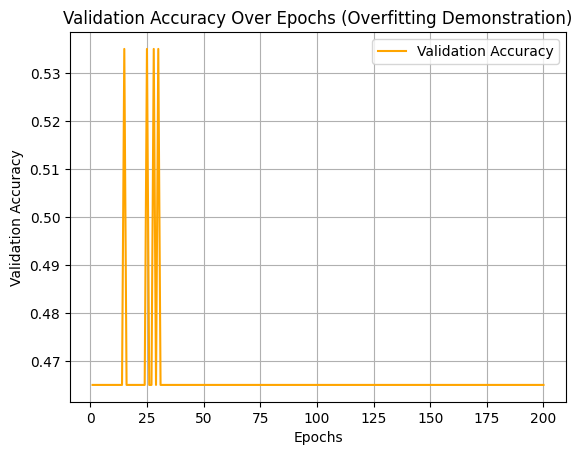

In [ ]:
history = train_overfitting_model(imagePath)
plot_validation_accuracy(history)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to visualize all pit images in the dataset
def visualize_pit(imagePath, pit_type='sig'):
    """
    Visualizes all pit images from the dataset in a grid.

    Parameters:
    - imagePath: Path to the dataset.
    - pit_type: Type of pit to visualize ('sig', 'bkg').
    """

    # load data
    pits_data = open_pits(imagePath + '/pits_checked')

    # unpack the data
    sig_array, bkg_array, _, _ = pits_data

    # select the pits based on the type
    if pit_type == 'sig':
        pit_images = sig_array
    elif pit_type == 'bkg':
        pit_images = bkg_array
    else:
        raise ValueError("Invalid pit_type. Choose from 'sig' or 'bkg'.")

    # determine grid size
    num_images = len(pit_images)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    # display all pit images in a grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    fig.suptitle(f'All {pit_type.upper()} Pit Images', fontsize=16)

    for i in range(grid_size * grid_size):
        row, col = divmod(i, grid_size)
        ax = axes[row, col]

        if i < num_images:
            ax.imshow(pit_images[i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # hide empty subplots

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()




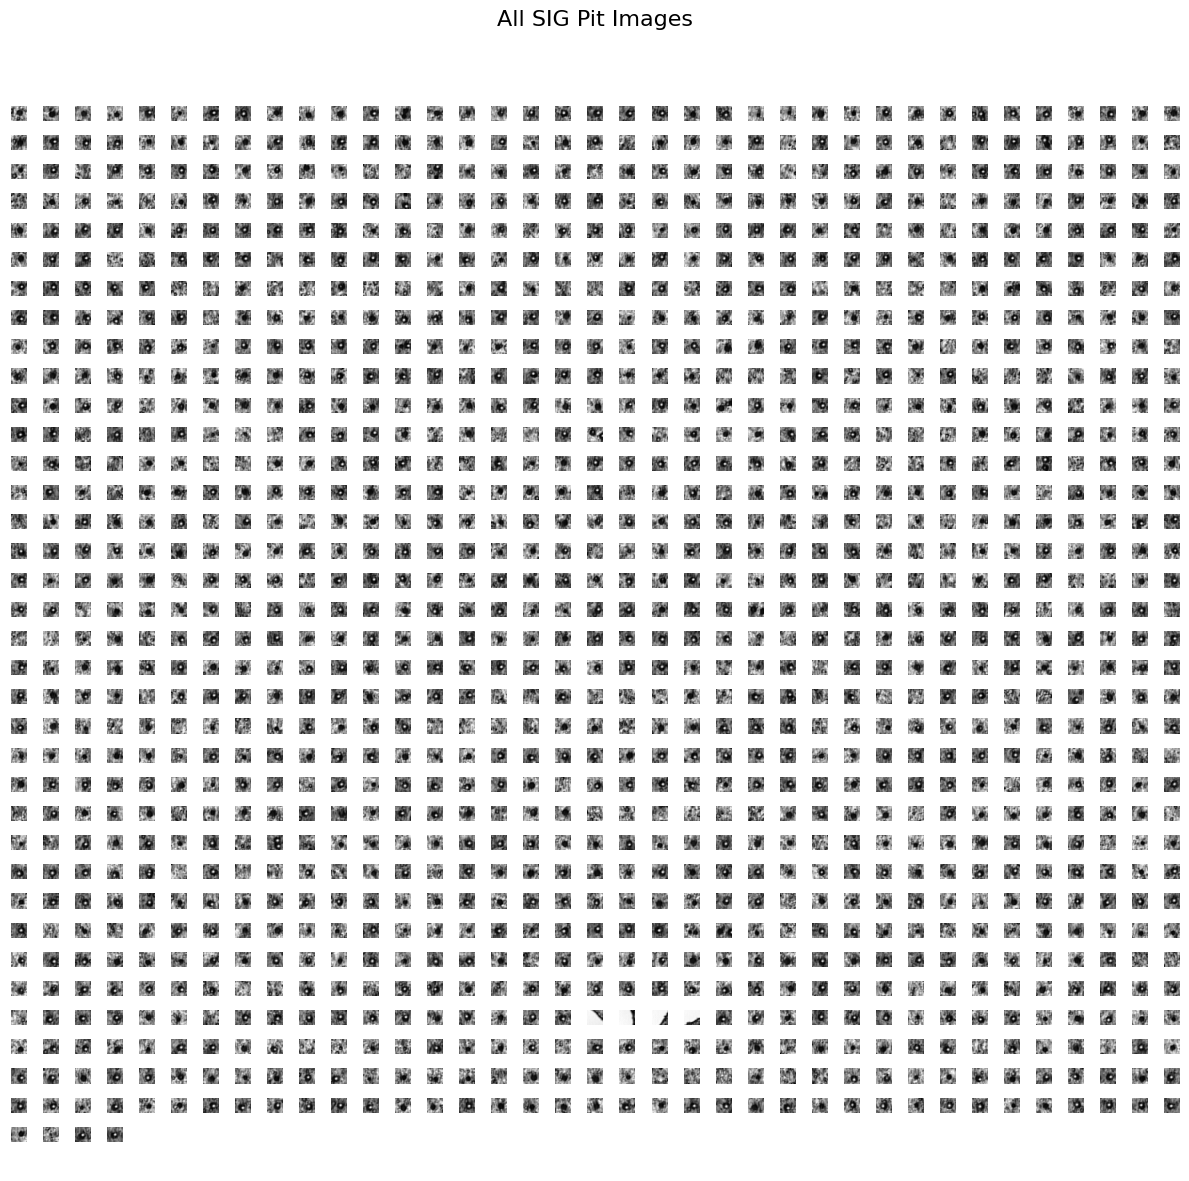

In [ ]:
visualize_pit(imagePath, pit_type='sig')

Below is the cross validation code

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# function for cross-validation training
def cross_validation_training(imagePath, n_splits=5):
    """
    Perform k-fold cross-validation for CNN training using the base model structure.

    Parameters:
    - imagePath: Path to the dataset.
    - n_splits: Number of folds for cross-validation (default is 5).
    """

    # load data
    s, b, sl, bl = open_pits(imagePath + '/pits_checked')

    # normalize data
    s, b = s / 255.0, b / 255.0

    # prepare data and labels
    data_all = np.concatenate((s, b), axis=0)
    label_all = np.concatenate((sl, bl), axis=0)

    # initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(data_all)):
        print(f'\nTraining on Fold {fold + 1}/{n_splits}')

        # split data
        data_train, data_val = data_all[train_idx], data_all[val_idx]
        label_train, label_val = label_all[train_idx], label_all[val_idx]

        # define model (base model structure)
        model = keras.Sequential()
        model.add(keras.Input(shape=(28, 28, 1)))  # Specifying input
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.GlobalMaxPooling2D())  # Compress to 1 spatial dimension
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # train model
        history = model.fit(
            data_train,
            label_train,
            epochs=10,  # Adjust epochs as needed
            batch_size=32,
            validation_data=(data_val, label_val),
            verbose=1
        )

        # evaluate model
        val_accuracy = history.history['val_accuracy'][-1]
        fold_accuracies.append(val_accuracy)
        print(f'Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}')

    # average accuracy across folds
    avg_accuracy = np.mean(fold_accuracies)
    print(f'\nAverage Validation Accuracy Across {n_splits} Folds: {avg_accuracy:.4f}')

    return fold_accuracies, avg_accuracy


In [ ]:
fold_accuracies, avg_accuracy = cross_validation_training(imagePath, n_splits=5)


Training on Fold 1/5
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5129 - loss: 0.6930 - val_accuracy: 0.5217 - val_loss: 0.6927
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5099 - loss: 0.6941 - val_accuracy: 0.5217 - val_loss: 0.6921
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5366 - loss: 0.6908 - val_accuracy: 0.5217 - val_loss: 0.6812
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6986 - loss: 0.5892 - val_accuracy: 0.9224 - val_loss: 0.2753
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9155 - loss: 0.2524 - val_accuracy: 0.9170 - val_loss: 0.2329
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9234 - loss: 0.2377 - val_accuracy: 0.9097 - val_loss: 0.2522
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9158 - loss: 0.2542 - val_accuracy: 0.9152 - val_loss: 0.2288
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9289 - loss: 0.2232 - va

Below is utilising bootstrap method

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import resample

# function to perform bootstrap sampling and calculate variance
def bootstrap_model_variance(imagePath, n_iterations=10):
    """
    Perform bootstrap sampling to evaluate model variance using the base model structure.

    Parameters:
    - imagePath: Path to the dataset.
    - n_iterations: Number of bootstrap samples (default is 10).
    """

    # load data
    s, b, sl, bl = open_pits(imagePath + '/pits_checked')

    # normalize data
    s, b = s / 255.0, b / 255.0

    # prepare data and labels
    data_all = np.concatenate((s, b), axis=0)
    label_all = np.concatenate((sl, bl), axis=0)

    accuracies = []

    for i in range(n_iterations):
        print(f'\nBootstrap Iteration {i + 1}/{n_iterations}')

        # bootstrap sampling
        data_sample, label_sample = resample(data_all, label_all, replace=True, random_state=i)

        # define model (base model structure)
        model = keras.Sequential()
        model.add(keras.Input(shape=(28, 28, 1)))  # specifying input
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(padding='same'))
        model.add(layers.GlobalMaxPooling2D())  # compress to 1 spatial dimension
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(2, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # train model
        history = model.fit(
            data_sample,
            label_sample,
            epochs=10,  # adjust epochs as needed
            batch_size=32,
            verbose=0  # suppress output for cleaner results
        )

        # evaluate the model
        final_accuracy = history.history['accuracy'][-1]
        accuracies.append(final_accuracy)
        print(f'Iteration {i + 1} Accuracy: {final_accuracy:.4f}')

    # calculate variance
    variance = np.var(accuracies)
    print(f'\nVariance of Model Accuracy Across {n_iterations} Bootstrap Samples: {variance:.6f}')

    return accuracies, variance

In [ ]:
accuracies, variance = bootstrap_model_variance(imagePath, n_iterations=10)


Bootstrap Iteration 1/10
Iteration 1 Accuracy: 0.9300

Bootstrap Iteration 2/10
Iteration 2 Accuracy: 0.9332

Bootstrap Iteration 3/10
Iteration 3 Accuracy: 0.9274

Bootstrap Iteration 4/10
Iteration 4 Accuracy: 0.9274

Bootstrap Iteration 5/10
Iteration 5 Accuracy: 0.9318

Bootstrap Iteration 6/10
Iteration 6 Accuracy: 0.9321

Bootstrap Iteration 7/10
Iteration 7 Accuracy: 0.9285

Bootstrap Iteration 8/10
Iteration 8 Accuracy: 0.9292

Bootstrap Iteration 9/10
Iteration 9 Accuracy: 0.9307

Bootstrap Iteration 10/10
Iteration 10 Accuracy: 0.9329

Variance of Model Accuracy Across 10 Bootstrap Samples: 0.000004


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

# function to create a heatmap for pit detection
def generate_pit_heatmap(imagePath, image_index=0):
    """
    Generate a heatmap to visualize pit detection results using the base model.

    Parameters:
    - imagePath: Path to the dataset.
    - image_index: Index of the image to generate the heatmap for.
    """

    # load the dataset
    s, _, _, _ = open_pits(imagePath + '/pits_checked')

    # select a sample image
    img = s[image_index]  # grayscale image
    img = img / 255.0  # normalize
    img_input = np.expand_dims(img, axis=(0, -1))  # reshape for model

    # define the base model
    def create_base_model():
        inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh')(inputs)
        x = layers.MaxPooling2D(padding='same')(x)
        x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh')(x)
        x = layers.MaxPooling2D(padding='same')(x)
        x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh')(x)
        x = layers.MaxPooling2D(padding='same')(x)
        x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh')(x)
        x = layers.MaxPooling2D(padding='same')(x)
        x = layers.GlobalMaxPooling2D()(x)
        x = layers.Dense(32, activation='relu')(x)
        outputs = layers.Dense(2, activation='softmax')(x)
        return keras.Model(inputs, outputs)

    model = create_base_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # identify the last convolutional layer dynamically
    conv_layers = [layer for layer in model.layers if isinstance(layer, layers.Conv2D)]
    if not conv_layers:
        raise ValueError("No Conv2D layer found in the model.")
    last_conv_layer = conv_layers[-1]

    # create a model that outputs the feature maps from the last conv layer
    heatmap_model = keras.Model(inputs=model.input, outputs=last_conv_layer.output)

    # get feature map
    feature_map = heatmap_model.predict(img_input)
    feature_map = np.squeeze(feature_map)  # Remove batch dimension

    # resize heatmap to match original image size
    heatmap = cv2.resize(feature_map.mean(axis=-1), (28, 28))

    # normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1

    # plot heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray', alpha=0.5)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.title("Pit Detection Heatmap")
    plt.axis("off")
    plt.show()

# example usage
# generate_pit_heatmap(imagePath, image_index=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


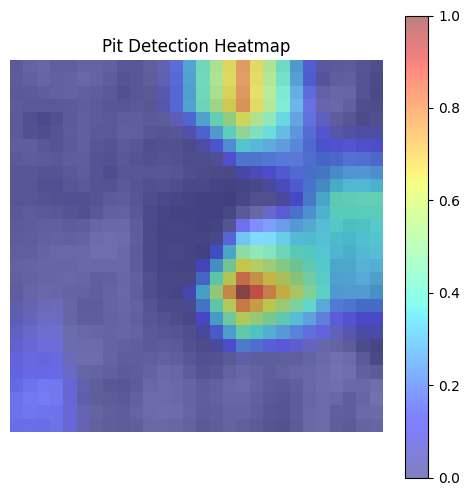

In [ ]:
generate_pit_heatmap(imagePath, image_index=5)